# Feedforward Network with Credit Card Fraud (Pipeline API version)

Please view the credit-card-fraud example, which will show how to do this in with an RDD-based approach. Here, we will follow the same approach with a dataframe-based pipeline API based on Spark MLLib.


In [36]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.models.ml_pipeline.dl_classifier import *
from utils import *

from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


init_engine()

In [37]:
learning_rate = 0.1
training_epochs = 100
batch_size = 10000
display_step = 1

# Network Parameters
n_input = 29
n_classes = 2
n_hidden_1 = 10 # 1st layer number of features


LABELS = ["Normal", "Fraud"]

cols = ["V" + str(x) for x in list(range(1,29))] + ["Amount"]
cols


['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [38]:
cc_training = spark.read.csv("../data/creditcardfraud/creditcard.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [39]:
cc_training.select('Time', 'V1', 'V2', 'Amount', 'Class').describe().show()

+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|summary|             Time|                  V1|                  V2|           Amount|              Class|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|  count|           284807|              284807|              284807|           284807|             284807|
|   mean|       94813.8596|2.260907382386083...|6.067406817137794...|88.34961925095207|   1.00172748563062|
| stddev|47488.14595456619|  1.9586958038574867|  1.6513085794769937|250.1201092401879|0.04152718963546483|
|    min|                0|    -56.407509631329|   -72.7157275629303|              0.0|                  1|
|    max|           172792|    2.45492999121121|    22.0577289904909|         25691.16|                  2|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+



In [40]:
cc_training = cc_training.select([col(c).cast("double") for c in cc_training.columns])
cc_training = cc_training.withColumn("label", cc_training["Class"])


## Dataset Balance

Let us see the dataset balance. We suspect a highly unbalanced dataset -- let us visualize. that.

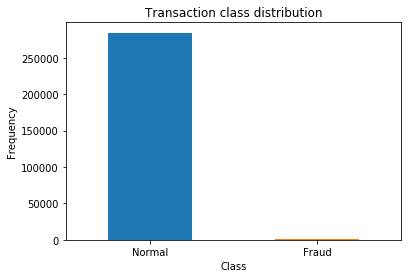

In [41]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('Class').toPandas()['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [42]:
# get the time to split the data.
splitTime = cc_training.stat.approxQuantile("Time", [0.7], 0.001)[0]

trainingData =cc_training.filter("Time < " + str(splitTime))
validData = cc_training.filter("Time >= " + str(splitTime))

## Feature analysis:
Normally it would improve the model if we could derive more features from the raw transaction records. E.g.
days to last transaction,
distance with last transaction,
amount percentage over the last 1 month / 3months
...

Yet with the public dataset, we can hardly derive any extention features from the PCA result. So here we only introduce several general practices:

Usually there's a lot of categorical data in the raw dataset, E.g. post code, card type, merchandise id, seller id, etc. 

1). For categorical feature with limited candidate values, like card type, channel id, just use OneHotEncoder. 

2). For categorical feature with many candidate values, like merchandise id, post code or even phone number, suggest to use Weight of Evidence. 

3). You can also use FeatureHasher from Spark MLlib which will be release with Spark 2.3.
For this dataset, essentially it's a classification problem with highly unbalanced data set.

## Approach

We will build a feature transform pipeline with Apache Spark and some of our transformers.
We will run some inital statistical analysis and split the dataset for training and validation.
We will build the model with BigDL.
We will compare different strategy to handle the unbalance.
Details of each step is as follows:

### step 1. Build an inital pipeline for feature transform.
For each training records, we intend to aggregate all the features into one Spark Vector, which will then be sent to BigDL model for the training. First we'd like to introduce one handy transformer that we developed to help user build custom Transformers for Spark ML Pipeline.
```
class FuncTransformer (
  override val uid: String,
  val func: UserDefinedFunction
) extends Transformer with HasInputCol with HasOutputCol with DefaultParamsWritable {
```
FuncTransformer takes an udf as the constructor parameter and use the udf to perform the actual transform. The transformer can be saved/loaded as other transformer and can be integrated into a pipeline normally. It can be used widely in many use cases like conditional conversion(if...else...), , type conversion, to/from Array, to/from Vector and many string ops. Some examples:
```
val labelConverter = new FuncTransformer(udf { i: Double => if (i >= 1) 1 else 0 })
```

```
val shifter = new FuncTransformer(udf { i: Double => i + 1 })
```

```
val toVector = new FuncTransformer(udf { i: Double => Vectors.dense(i) })
```

We will use VectorAssembler to compose the all the Vx columns and append the Amount column. Then use StandardScaler to normlize the training records. Since in BigDL, the criterion generally only accepts 1, 2, 3... as the Label, so we will replace all the 0 with 2 in the training data.

In [43]:
assembler =  VectorAssembler(inputCols=cols, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(trainingData)
data_training = pipelineTraining.transform(trainingData)
pipelineTest = pipeline.fit(validData)
data_test = pipelineTest.transform(validData)

## step 2. Build the model with BigDL
From the research community and industry feedback, a simple neural network turns out be the perfect candidate for the fraud detection training. We will quickly build a multiple layer Perceptron with linear layers.
```
    val bigDLModel = Sequential()
      .add(Linear(29, 10))
      .add(Linear(10, 2))
      .add(LogSoftMax())
    val criterion = ClassNLLCriterion()
```

BigDL provides DLEstimator and DLClassifier for users with Apache Spark MLlib experience, which provides high level API for training a BigDL Model with the Apache Spark Estimator/Transfomer pattern, thus users can conveniently fit BigDL into a ML pipeline. The fitted model DLModel and DLClassiferModel contains the trained BigDL model and extends the Spark ML Model class. Alternatively users may also construct a DLModel with a pre-trained BigDL model to use it in Spark ML Pipeline for prediction.

DLClassifier is a specialized DLEstimator that simplifies the data format for classification tasks. It only supports label column of DoubleType, and the fitted DLClassifierModel will have the prediction column of DoubleType.

For this case we'll just use DLClassifier for the training. Note that users can set differet optimization mothod, batch size and epoch number.


In [44]:

bigDLModel = Sequential().add(Linear(n_input, n_hidden_1)).add(Linear(n_hidden_1, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("label").setMaxEpoch(training_epochs).setBatchSize(batch_size)
model = dlClassifier.fit(data_training)
print("\ninitial model training finished.")

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createDLClassifier

initial model training finished.


In [45]:
from pyspark.sql import DataFrame, SQLContext
predictionDF = DataFrame(model.transform(data_test), SQLContext(sc))
predictionDF

DataFrame[Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: double, label: double, assembled: vector, features: vector, prediction: double]

# Evaluate our Model

Now we are goin to do the Precision, Recall, and AUC. To evaluate our model.

In [46]:
predictionDF.cache() 
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + str(auPRC))
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + str(recall))

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + str(precision))  
predictionDF.unpersist()


Area under precision-recall curve: = 1.0

recall = 0.998458934096

Precision = 0.998246759394


DataFrame[Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: double, label: double, assembled: vector, features: vector, prediction: double]

In [47]:
y_pred = np.array(predictionDF.select('prediction').collect())
y_true = np.array(predictionDF.select('label').collect())

The prediction accuracy is 99.85%


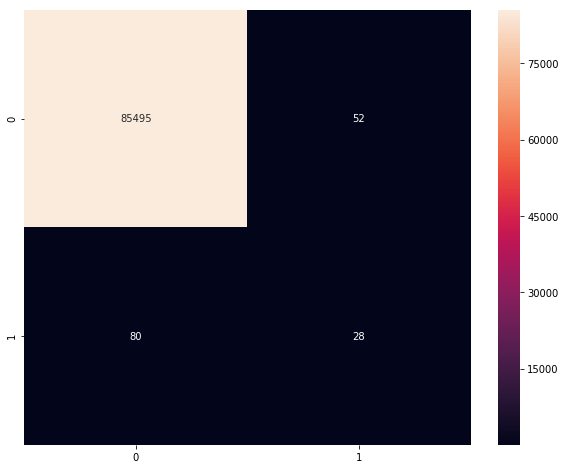

In [48]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');